In [1]:
import numpy as np
import casadi as cs
import os
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

from quad import Quadrotor3D
from utils import skew_symmetric, quaternion_to_euler, unit_quat, v_dot_q


Define the quadrotor dynamics in Casadi

In [2]:
'''
quad = Quadrotor3D()

p = cs.MX.sym('p',3) # Position
q = cs.MX.sym('q',4) # Quaternion

v = cs.MX.sym('v',3) # Velocity
r = cs.MX.sym('w',3) # Angle rate

x = cs.vertcat(p,q,v,r) # the complete state

# Control variables
u1 = cs.MX.sym('u1')
u2 = cs.MX.sym('u2')
u3 = cs.MX.sym('u3')
u4 = cs.MX.sym('u4')

u = cs.vertcat(u1,u2,u3,u4) # complete control

# d position 
f_p = v # position dynamics

# d quaternion
f_q = 1 / 2 * cs.mtimes(skew_symmetric(r),q) # quaternion dynamics

# d velocity
f_thrust = u*quad.max_thrust
a_thrust = cs.vertcat(0, 0, f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3]) / quad.mass
g = cs.vertcat(0,0,9.81)

f_v = v_dot_q(a_thrust, q) - g # velocity dynamics

# d rate
y_f = cs.MX(quad.y_f)
x_f = cs.MX(quad.x_f)
c_f = cs.MX(quad.z_l_tau)
# rate dynamics
f_r =  cs.vertcat(
    (cs.mtimes(f_thrust.T, y_f) + (quad.J[1] - quad.J[2]) * r[1] * r[2]) / quad.J[0],
    (-cs.mtimes(f_thrust.T, x_f) + (quad.J[2] - quad.J[0]) * r[2] * r[0]) / quad.J[1],
    (cs.mtimes(f_thrust.T, c_f) + (quad.J[0] - quad.J[1]) * r[0] * r[1]) / quad.J[2])


# concatenated dynamics
x_dot = cs.vertcat(f_p, f_q, f_v, f_r)
# Casadi function for dynamics 
dynamics = cs.Function('x_dot', [x,u], [x_dot], ['x','u'], ['x_dot'])


dynamics(np.zeros((13,)), np.ones((4,)))

'''

"\nquad = Quadrotor3D()\n\np = cs.MX.sym('p',3) # Position\nq = cs.MX.sym('q',4) # Quaternion\n\nv = cs.MX.sym('v',3) # Velocity\nr = cs.MX.sym('w',3) # Angle rate\n\nx = cs.vertcat(p,q,v,r) # the complete state\n\n# Control variables\nu1 = cs.MX.sym('u1')\nu2 = cs.MX.sym('u2')\nu3 = cs.MX.sym('u3')\nu4 = cs.MX.sym('u4')\n\nu = cs.vertcat(u1,u2,u3,u4) # complete control\n\n# d position \nf_p = v # position dynamics\n\n# d quaternion\nf_q = 1 / 2 * cs.mtimes(skew_symmetric(r),q) # quaternion dynamics\n\n# d velocity\nf_thrust = u*quad.max_thrust\na_thrust = cs.vertcat(0, 0, f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3]) / quad.mass\ng = cs.vertcat(0,0,9.81)\n\nf_v = v_dot_q(a_thrust, q) - g # velocity dynamics\n\n# d rate\ny_f = cs.MX(quad.y_f)\nx_f = cs.MX(quad.x_f)\nc_f = cs.MX(quad.z_l_tau)\n# rate dynamics\nf_r =  cs.vertcat(\n    (cs.mtimes(f_thrust.T, y_f) + (quad.J[1] - quad.J[2]) * r[1] * r[2]) / quad.J[0],\n    (-cs.mtimes(f_thrust.T, x_f) + (quad.J[2] - quad.J[0]) * r[

Test integrating the dynamics by FE

In [3]:
'''
x_new = np.array([0,0,0, 1,0,1,0, 0,0,0, 0,0,0])
u_new = np.array([1,1,1,1])


N = 10
dt = 0.01
for i in range(N):
    x_new = x_new + dt*dynamics(x_new, u_new)
    print(x_new)
'''

'\nx_new = np.array([0,0,0, 1,0,1,0, 0,0,0, 0,0,0])\nu_new = np.array([1,1,1,1])\n\n\nN = 10\ndt = 0.01\nfor i in range(N):\n    x_new = x_new + dt*dynamics(x_new, u_new)\n    print(x_new)\n'

Now to define the Optimal Control Problem

Cost function:
$l(x,u) = \vert \vert V_x x + V_u u - y_{ref} \vert \vert^2_W$

In [4]:
def setup_ocp():
    x_dot = cs.MX.sym('x_dot', dynamics(x=x, u=u)['x_dot'].shape) # x_dot has the same dimensions as the dynamics function output
    #print(dynamics(x=x, u=u)['x_dot'])

    optimization_dt = 5e-2 # dt between predicted states
    #n_nodes = 100 # number of predicted states
    t_horizon = n_nodes*optimization_dt # look-ahead time

    terminal_cost = 1

    acados_model = AcadosModel()


    acados_model.name = 'quad_OCP'
    acados_model.x = x
    acados_model.u = u
    #acados_model.x_dot = x_dot


    acados_model.f_expl_expr = dynamics(x=x, u=u)['x_dot'] # x_dot = f
    acados_model.f_impl_expr = x_dot - dynamics(x=x, u=u)['x_dot'] # 0 = f - x_dot

    #print(acados_model)

    acados_source_path = os.environ['ACADOS_SOURCE_DIR']

    acados_ocp = AcadosOcp()

    acados_ocp.acados_include_path = acados_source_path + '/include'
    acados_ocp.acados_lib_path = acados_source_path + '/lib'

    acados_ocp.model = acados_model
    acados_ocp.dims.N = n_nodes # prediction horizon
    acados_ocp.solver_options.tf = t_horizon # look ahead time

    acados_ocp.cost.cost_type = 'LINEAR_LS' # weigths times states (as opposed to a nonlinear relationship)
    acados_ocp.cost.cost_type_e = 'LINEAR_LS' # end state cost


    nx = acados_model.x.size()[0]
    nu = acados_model.u.size()[0]
    ny = nx + nu # y is x and u concatenated for compactness of the loss function

    ## Optimization costs
    acados_ocp.cost.Vx = np.zeros((ny,nx)) # raise the dim of x to the dim of y
    acados_ocp.cost.Vx[:nx, :nx] = np.eye(nx) # weight only x
    acados_ocp.cost.Vx_e = np.eye(nx) # end x cost

    acados_ocp.cost.Vu = np.zeros((ny,nu)) # raise the dim of u to the dim of y
    acados_ocp.cost.Vu[-nu:, -nu:] = np.eye(nu) # weight only u

    # x cost (dim 12)
    q_cost = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # euler angles
    # add one more weigth to account for the 4 quaternions instead of 3 EA
    q_diagonal = np.concatenate((q_cost[:3], np.mean(q_cost[3:6])[np.newaxis], q_cost[3:]))
    r_cost = np.array([0.1, 0.1, 0.1, 0.1]) # u cost (dim 4)
    acados_ocp.cost.W = np.diag(np.concatenate((q_diagonal, r_cost))) # error costs
    acados_ocp.cost.W_e = np.diag(q_diagonal) * terminal_cost # end error cost


    # reference trajectory (will be overwritten later, this is just for dimensions)
    x_ref = np.zeros(nx)
    acados_ocp.cost.yref = np.concatenate((x_ref, np.array([0.0, 0.0, 0.0, 0.0])))
    #print(acados_ocp.cost.yref.shape)
    acados_ocp.cost.yref_e = x_ref

    acados_ocp.constraints.x0 = x_ref

    acados_ocp.constraints.lbu = np.array([0] * 4)
    acados_ocp.constraints.ubu = np.array([1] * 4)
    acados_ocp.constraints.idxbu = np.array([0,1,2,3]) # Indices of bounds on u 

    ## Solver options
    acados_ocp.solver_options.qp_solver = 'FULL_CONDENSING_HPIPM'
    acados_ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
    acados_ocp.solver_options.integrator_type = 'ERK'
    acados_ocp.solver_options.print_level = 0
    acados_ocp.solver_options.nlp_solver_type = 'SQP_RTI'

    # Compile acados OCP solver if necessary
    json_file = '_acados_ocp.json'

    #print(acados_ocp.items())

    #print(acados_model['x_dot'])
    acados_ocp_solver = AcadosOcpSolver(acados_ocp)#, json_file=json_file)
    
    return acados_ocp_solver






In [13]:
class quad_optimizer:
    def __init__(self, quad, optimization_dt=5e-2, n_nodes=100):
        
        self.n_nodes = n_nodes
        self.optimization_dt = optimization_dt
        self.t_horizon = self.n_nodes*self.optimization_dt # look-ahead time
        
        self.quad = quad # quad is needed to create the casadi model using quad parameters
        self.dynamics = self.setup_casadi_model()
        
        self.x_dot = cs.MX.sym('x_dot', self.dynamics(x=self.x, u=self.u)['x_dot'].shape)  # x_dot has the same dimensions as the dynamics function output

        #print(dynamics(x=x, u=u)['x_dot'])

        #optimization_dt = 5e-2 # dt between predicted states
        #n_nodes = 100 # number of predicted states
        

        self.terminal_cost = 1

        self.acados_model = AcadosModel()


        self.acados_model.name = 'quad_OCP'
        self.acados_model.x = self.x
        self.acados_model.u = self.u
        #acados_model.x_dot = x_dot

        self.acados_model.f_expl_expr = self.dynamics(x=self.x, u=self.u)['x_dot'] # x_dot = f
        self.acados_model.f_impl_expr = self.x_dot - self.dynamics(x=self.x, u=self.u)['x_dot'] # 0 = f - x_dot

        #print(acados_model)

        self.acados_source_path = os.environ['ACADOS_SOURCE_DIR']

        self.acados_ocp = AcadosOcp()

        self.acados_ocp.acados_include_path = self.acados_source_path + '/include'
        self.acados_ocp.acados_lib_path = self.acados_source_path + '/lib'

        self.acados_ocp.model = self.acados_model
        self.acados_ocp.dims.N = self.n_nodes # prediction horizon
        self.acados_ocp.solver_options.tf = self.t_horizon # look ahead time

        self.acados_ocp.cost.cost_type = 'LINEAR_LS' # weigths times states (as opposed to a nonlinear relationship)
        self.acados_ocp.cost.cost_type_e = 'LINEAR_LS' # end state cost


        self.nx = self.acados_model.x.size()[0]
        self.nu = self.acados_model.u.size()[0]
        self.ny = self.nx + self.nu # y is x and u concatenated for compactness of the loss function

        ## Optimization costs
        self.acados_ocp.cost.Vx = np.zeros((self.ny, self.nx)) # raise the dim of x to the dim of y
        self.acados_ocp.cost.Vx[:self.nx, :self.nx] = np.eye(self.nx) # weight only x
        self.acados_ocp.cost.Vx_e = np.eye(self.nx) # end x cost

        self.acados_ocp.cost.Vu = np.zeros((self.ny, self.nu)) # raise the dim of u to the dim of y
        self.acados_ocp.cost.Vu[-self.nu:, -self.nu:] = np.eye(self.nu) # weight only u

        # x cost (dim 12)
        q_cost = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]) # euler angles
        # add one more weigth to account for the 4 quaternions instead of 3 EA
        q_diagonal = np.concatenate((q_cost[:3], np.mean(q_cost[3:6])[np.newaxis], q_cost[3:]))
        r_cost = np.array([0.1, 0.1, 0.1, 0.1]) # u cost (dim 4)
        self.acados_ocp.cost.W = np.diag(np.concatenate((q_diagonal, r_cost))) # error costs
        self.acados_ocp.cost.W_e = np.diag(q_diagonal) * self.terminal_cost # end error cost


        # reference trajectory (will be overwritten later, this is just for dimensions)
        x_ref = np.zeros(self.nx)
        self.acados_ocp.cost.yref = np.concatenate((x_ref, np.array([0.0, 0.0, 0.0, 0.0])))
        #print(acados_ocp.cost.yref.shape)
        self.acados_ocp.cost.yref_e = x_ref # end node reference

        self.acados_ocp.constraints.x0 = x_ref

        # u constraints
        self.acados_ocp.constraints.lbu = np.array([0] * self.nu)
        self.acados_ocp.constraints.ubu = np.array([1] * self.nu)
        self.acados_ocp.constraints.idxbu = np.array([0,1,2,3]) # Indices of bounds on u 

        ## Solver options
        self.acados_ocp.solver_options.qp_solver = 'FULL_CONDENSING_HPIPM'
        self.acados_ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
        self.acados_ocp.solver_options.integrator_type = 'ERK'
        self.acados_ocp.solver_options.print_level = 0
        self.acados_ocp.solver_options.nlp_solver_type = 'SQP_RTI'

        # Compile acados OCP solver if necessary
        json_file = '_acados_ocp.json'
        
        self.acados_ocp_solver = AcadosOcpSolver(self.acados_ocp)#, json_file=json_file)
        
    def setup_casadi_model(self):
        
        self.p = cs.MX.sym('p',3) # Position
        self.q = cs.MX.sym('q',4) # Quaternion

        self.v = cs.MX.sym('v',3) # Velocity
        self.r = cs.MX.sym('w',3) # Angle rate

        self.x = cs.vertcat(self.p,self.q,self.v,self.r) # the complete state

        # Control variables
        u1 = cs.MX.sym('u1')
        u2 = cs.MX.sym('u2')
        u3 = cs.MX.sym('u3')
        u4 = cs.MX.sym('u4')

        self.u = cs.vertcat(u1,u2,u3,u4) # complete control

        # d position 
        f_p = self.v # position dynamicss

        # d quaternion
        f_q = 1 / 2 * cs.mtimes(skew_symmetric(self.r),self.q) # quaternion dynamics

        # d velocity
        f_thrust = self.u*self.quad.max_thrust
        a_thrust = cs.vertcat(0, 0, f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3]) / self.quad.mass
        self.g = cs.vertcat(0,0,9.81)
        f_v = v_dot_q(a_thrust, self.q) - self.g # velocity dynamics

        # d rate
        y_f = cs.MX(self.quad.y_f)
        x_f = cs.MX(self.quad.x_f)
        c_f = cs.MX(self.quad.z_l_tau)
        # rate dynamics
        f_r =  cs.vertcat(
            (cs.mtimes(f_thrust.T, y_f) + (self.quad.J[1] - self.quad.J[2]) * self.r[1] * self.r[2]) / self.quad.J[0],
            (-cs.mtimes(f_thrust.T, x_f) + (self.quad.J[2] - self.quad.J[0]) * self.r[2] * self.r[0]) / self.quad.J[1],
            (cs.mtimes(f_thrust.T, c_f) + (self.quad.J[0] - self.quad.J[1]) * self.r[0] * self.r[1]) / self.quad.J[2])


        # concatenated dynamics
        x_dot = cs.vertcat(f_p,f_q, f_v, f_r)
        
        # Casadi function for dynamics 
        return cs.Function('x_dot', [self.x,self.u], [x_dot], ['x','u'], ['x_dot'])

    
    # this does not do anything, I want to use the acados ocp solver to make predictions, not the internal quad object, that exists only to get the model parameters
    def set_quad_state(self, x):
        self.quad.set_state(x)
        
    def set_reference_state(self, x_target=None, u_target=None):
        if u_target is None:
            u_target = np.array([0,0,0,0])
        if x_target is None:
            x_target = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0])


        self.yref = np.empty((self.n_nodes, x_target.shape[0] + u_target.shape[0])) # prepare memory, N x ny 
        for j in range(self.n_nodes):
            self.yref[j,:] = np.concatenate((x_target, u_target)) # load desired trajectory into yref
            #print(self.yref[j,:])
            self.acados_ocp_solver.set(j, "yref", self.yref[j,:]) # supply desired trajectory to ocp

        # end point of the trajectory has no desired u 
        self.yref_N = x_target
        self.acados_ocp_solver.set(self.n_nodes, "yref", self.yref_N) # dimension nx

        return self.yref, self.yref_N
    

    
    def run_optimization(self, x_init=None):

        if x_init is None:
            x_init = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0]) 

        # set initial conditions
        self.acados_ocp_solver.set(0, 'lbx', x_init) # not sure what these two lines do. Set the lower and upper bound for x to the same value?
        self.acados_ocp_solver.set(0, 'ubx', x_init)
        self.acados_ocp_solver.set(0, 'x', x_init)

        # Solve OCP
        self.acados_ocp_solver.solve()

        #print(x_init)

        # preallocate memory
        w_opt_acados = np.ndarray((self.n_nodes, 4)) 
        x_opt_acados = np.ndarray((self.n_nodes + 1, len(x_init)))
        x_opt_acados[0, :] = self.acados_ocp_solver.get(0, "x") # should be x_init?

        # write down the optimal solution
        for i in range(self.n_nodes):
            w_opt_acados[i, :] = self.acados_ocp_solver.get(i, "u") # optimal control
            x_opt_acados[i + 1, :] = self.acados_ocp_solver.get(i + 1, "x") # state under optimal control

        #w_opt_acados = np.reshape(w_opt_acados, (-1))
        return (x_opt_acados, w_opt_acados)

Add a reference trajectory

In [6]:
def set_reference_state(x_target=None, u_target=None):
    if u_target is None:
        u_target = np.array([0,0,0,0])
    if x_target is None:
        x_target = np.array([0,0,1, 1,0,0,0, 0,0,0, 0,0,0], dtype=float)
        
        
    yref = np.empty((n_nodes,ny)) # prepare memory, N x ny 
    for j in range(n_nodes):
        yref[j,:] = np.concatenate(( x_target, u_target)) # load desired trajectory into yref
        acados_ocp_solver.set(j, "yref", yref[j,:]) # supply desired trajectory to ocp

    # end point of the trajectory has no desired u 
    yref_N = x_target
    acados_ocp_solver.set(n_nodes, "yref", yref_N) # dimension nx

    return yref, yref_N

In [7]:
def run_optimization(x_init=None):
    
    if x_init is None:
        x_init = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0]) 
    
    # set initial conditions
    acados_ocp_solver.set(0, 'lbx', x_init) # not sure what these two lines do. Set the lower and upper bound for x to the same value?
    acados_ocp_solver.set(0, 'ubx', x_init)
    acados_ocp_solver.set(0, 'x', x_init)
    
    # Solve OCP
    acados_ocp_solver.solve()
    
    #print(x_init)
    
    # preallocate memory
    w_opt_acados = np.ndarray((n_nodes, 4)) 
    x_opt_acados = np.ndarray((n_nodes + 1, len(x_init)))
    x_opt_acados[0, :] = acados_ocp_solver.get(0, "x") # should be x_init?
    
    # write down the optimal solution
    for i in range(n_nodes):
        w_opt_acados[i, :] = acados_ocp_solver.get(i, "u") # optimal control
        x_opt_acados[i + 1, :] = acados_ocp_solver.get(i + 1, "x") # state under optimal control

    #w_opt_acados = np.reshape(w_opt_acados, (-1))
    return x_opt_acados, w_opt_acados


In [8]:
def square_trajectory():
    dt = optimization_dt
    v_max = 10
    
    t_section = np.arange(0,n_nodes*dt/4,dt)
    p0 = np.array([0,0,0])
    v = np.array([v_max,0,0])
    p_target = p0[np.newaxis,:] + v*t_section[:,np.newaxis]
    
    p0 = p_target[-1,:]
    v = np.array([0,v_max,0])
    p_target = np.concatenate((p_target, p0[np.newaxis,:] + v*t_section[:,np.newaxis]))
    
    p0 = p_target[-1,:]
    v = np.array([-v_max,0,0])
    p_target = np.concatenate((p_target, p0[np.newaxis,:] + v*t_section[:,np.newaxis]))
    
    p0 = p_target[-1,:]
    v = np.array([0,-v_max,0])
    p_target = np.concatenate((p_target, p0[np.newaxis,:] + v*t_section[:,np.newaxis]))    
    
    x_target = np.zeros((p_target.shape[0], nx))
    x_target[:,3] = 1
    x_target[:,0:3] = p_target
    return x_target




In [9]:
def set_reference_trajectory(x_trajectory=None, u_trajectory=None):
    
    yref = np.empty((n_nodes,ny)) # prepare memory, N x ny 
    for j in range(n_nodes):
        #print(j)
        yref[j,:] = np.concatenate((x_trajectory[j,:], u_trajectory[j,:])) # load desired trajectory into yref
        #print(yref[j,:])
        acados_ocp_solver.set(j, "yref", yref[j,:]) # supply desired trajectory to ocp

    # end point of the trajectory has no desired u 
    yref_N = x_trajectory[-1,:]
    acados_ocp_solver.set(n_nodes, "yref", yref_N) # dimension nx

    return yref, yref_N

In [10]:
# I need to chunk the reference trajectory

rm -f libacados_ocp_solver_quad_OCP.so
rm -f acados_solver_quad_OCP.o
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o acados_solver_quad_OCP.o acados_solver_quad_OCP.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_ode_fun.o quad_OCP_model/quad_OCP_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/ja/Projects/MPC_drone/acados/include -I/home/ja/Projects/MPC_drone/acados/include/acados -I/home/ja/Projects/MPC_drone/acados/include/blasfeo/include -I/home/ja/Projects/MPC_drone/acados/include/hpipm/include  -c -o quad_OCP_model/quad_OCP_expl_vde_forw.o quad_OCP_model/qua

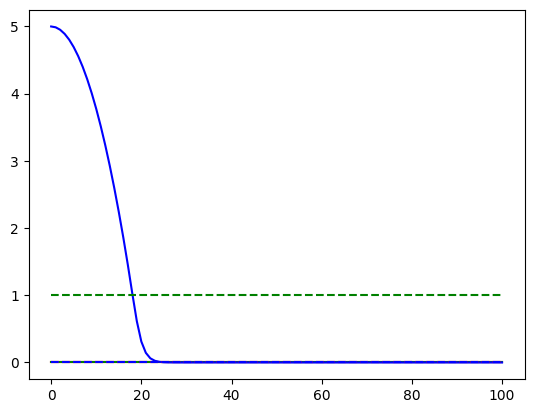

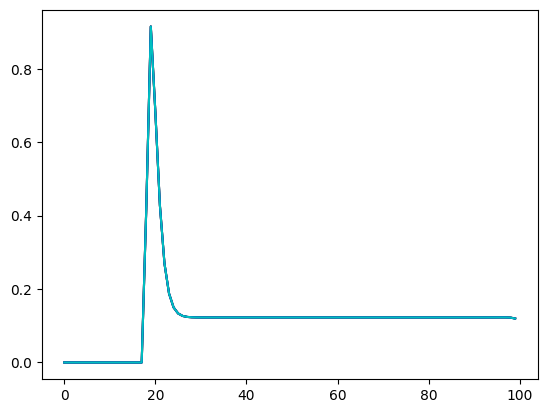

In [14]:
x0 = np.array([0,0,5, 1,0,0,0, 0,0,0, 0,0,0])

#x_target = np.array([3,2,2, 1,0,0,0, 0,0,0, 0,0,0])
#u_target = np.array([0,0,0,0])
'''
x_trajectory = square_trajectory()
print(x_trajectory[:,0])
u_trajectory = np.ones((x_trajectory.shape[0], 4))*0.16 # 0.16 is hover thrust 
'''

#yref, yref_N = set_reference_trajectory(x_trajectory, u_trajectory)
quad_opt = quad_optimizer(Quadrotor3D())
#quad_opt.set_quad_state(x0)
yref, yref_N = quad_opt.set_reference_state(np.array([0,1,0, 1,0,0,0, 0,1,0, 0,0,0]))
x_opt_acados, w_opt_acados = quad_opt.run_optimization(x0)
print(quad_opt.acados_ocp_solver.get_cost())

fig = plt.figure()
plt.plot(x_opt_acados[:,0],'r')
plt.plot(x_opt_acados[:,1],'g')
plt.plot(x_opt_acados[:,2],'b')


plt.plot(np.concatenate((yref[:quad_opt.n_nodes,0], [yref_N[0]])),'r--')
plt.plot(np.concatenate((yref[:quad_opt.n_nodes,1], [yref_N[1]])),'g--')
plt.plot(np.concatenate((yref[:quad_opt.n_nodes,2], [yref_N[2]])), 'b--')

fig = plt.figure()
plt.plot(w_opt_acados[:,0],'r')
plt.plot(w_opt_acados[:,1],'g')
plt.plot(w_opt_acados[:,2],'b')
plt.plot(w_opt_acados[:,3],'c')

#print(x_opt_acados)
#print(w_opt_acados)
#acados_ocp.cost.yref

import pickle

pickle.dump(x_opt_acados, open( "x_opt.p", "wb" ) )

In [12]:
x0 = np.array([0,0,1, 1,0,0,0, 0,0,0, 0,0,0])
n_nodes = 100
ny = 17
nx = 13
nu = 4
optimization_dt = 5e-2

#print(x_target.shape)
x_trajectory  = square_trajectory()
u_trajectory = np.ones((x_trajectory.shape[0], 4))*0.16

print(x_trajectory.shape)
print(u_trajectory.shape)
#x_target = np.array([3,2,2, 1,0,0,0, 0,0,0, 0,0,0])
#u_target = np.array([0,0,0,0])
'''
x_trajectory = square_trajectory()
print(x_trajectory[:,0])
u_trajectory = np.ones((x_trajectory.shape[0], 4))*0.16 # 0.16 is hover thrust 
'''
acados_ocp_solver = setup_ocp()
#print(x_target.shape)
yref, yref_N = set_reference_trajectory(x_trajectory, u_trajectory)
#quad_opt = quad_optimizer(Quadrotor3D())
#quad_opt.set_quad_state(x0)

#yref, yref_N = set_reference_state(np.array([0,1,1, 1,0,0,0, 0,1,0, 0,0,0]))
x_opt_acados, w_opt_acados = run_optimization(x0)
print(acados_ocp_solver.get_cost())

fig = plt.figure()
plt.plot(x_opt_acados[:,0],'r')
plt.plot(x_opt_acados[:,1],'g')
plt.plot(x_opt_acados[:,2],'b')


plt.plot(np.concatenate((yref[:n_nodes,0], [yref_N[0]])),'r--')
plt.plot(np.concatenate((yref[:n_nodes,1], [yref_N[1]])),'g--')
plt.plot(np.concatenate((yref[:n_nodes,2], [yref_N[2]])), 'b--')

fig = plt.figure()
plt.plot(w_opt_acados[:,0],'r')
plt.plot(w_opt_acados[:,1],'g')
plt.plot(w_opt_acados[:,2],'b')
plt.plot(w_opt_acados[:,3],'c')

(100, 13)
(100, 4)


NameError: name 'dynamics' is not defined

In [ ]:
Nsim = 5 # number of simulation steps
simulation_dt = 5e-4


acados_solver = setup_ocp()
yref, yref_N = set_reference_state(np.array([0,10,1, 1,0,0,0, 0,0,0, 0,0,0]))


x = np.array([0,0,0, 1,0,0,0, 0,0,0, 0,0,0], dtype=float)

#x = np.array([1.080603418249914e-05, -1.6839683995820306e-09, -0.046173089844097515, 0.999936466653564, 2.3413072940611493e-06, 0.011267897388494184, -0.00031167185759714046, 0.00043222760479262075, -1.683968334148989e-07, -0.9234642321593282, 0.0001873045833992675, 0.4507254188112745, -0.012466874497293369]
#, dtype=float)

quad_sim = Quadrotor3D()


x_optim = np.empty((Nsim*n_nodes+1,13))
u_optim = np.empty((Nsim*n_nodes,4))

xsim[0,:] = x
quad_sim.set_state(x)

for i in range(Nsim):
    x_opt_acados, w_opt_acados = run_optimization(x)
    
    '''
    fig = plt.figure()
    plt.plot(x_opt_acados[:,0],'r')
    plt.plot(x_opt_acados[:,1],'g')
    plt.plot(x_opt_acados[:,2], 'b')


    plt.plot(np.concatenate((yref[:N,0], [yref_N[0]])),'r--')
    plt.plot(np.concatenate((yref[:N,1], [yref_N[1]])),'g--')
    plt.plot(np.concatenate((yref[:N,2], [yref_N[2]])), 'b--')
    '''
    '''
    fig = plt.figure()
    plt.plot(w_opt_acados[:,0],'r')
    plt.plot(w_opt_acados[:,1],'g')
    plt.plot(w_opt_acados[:,2], 'b')
    plt.plot(w_opt_acados[:,3], 'c')
    '''
    control_time = 0
    while control_time < optimization_dt: # control the quad with the most recent u for the whole control period (multiple simulation steps for one optimization)
        quad_sim.update(w_opt_acados[0,:], simulation_dt)
        control_time += simulation_dt
        
        u_optim[i,:] = w_opt_acados[0,:]
        x_optim[i+1,:] = x
         
    x = np.array(quad_sim.get_state(quaternion=True, stacked=True)) # state at the next optim step
    


    #print(x)

    
fig = plt.figure()
plt.plot(xsim[:,0],'r')
plt.plot(xsim[:,1],'g')
plt.plot(xsim[:,2], 'b')


plt.plot(np.concatenate((yref[:N,0], [yref_N[0]])),'r--')
plt.plot(np.concatenate((yref[:N,1], [yref_N[1]])),'g--')
plt.plot(np.concatenate((yref[:N,2], [yref_N[2]])), 'b--')

fig = plt.figure()
plt.plot(usim[:,0],'r')
plt.plot(usim[:,1],'g')
plt.plot(usim[:,2], 'b')
plt.plot(usim[:,3], 'c')
